# Measuring and predicting posts success for tumblr/design/fashion bloggers

# Collecting data

1. The data will be colected from Tumblr Api 
2. Tumblr Api is a generous API that enables the developer to request 1000 queries every hour up to 5 hours, and depending on the users privacy settings, all information relevant to blogs, posts of a particular user or tags of a particular subject.
3. For the purposes of my project, I want to explore the tagged data for a particular subject in design/fashion bloggers, such as street style (which presumibly includes men, women)
4. My hypothesis is that there should be a measure of success for a particular post, based on different features given by the data.


The following lines of code make one 'tagged' request for 20 posts (default value)

### The following script collects data for a particular 'tag' or subject in loops. Each request the developer can make
to Tumblr API is for the most recent posts, strating on a date given by the developer. That means that we have to request in a loop that traces back to the last post collected, stores its date and redefines the last date as this new stored date.

In [8]:
%%writefile postGather_tag.py
from __future__ import division
import pandas as pd
import numpy as np

import sys
import time

#API:
import pytumblr

#Personal package:
import cleaning

#Generator to grab posts from a series of hashtags:
def PostGenerator(client, tag, timelist = [],rep = 1):
    """Generator to get posts from Tumblr API.
    client = tumblr client
    tag = tag to search for
    timelist = times to search at
    rep = repetition rate, if using timelist
    """
    
    #Grab 20 or less:
    chunk=20
    #Just a counter:
    i=0
    j=0
    #For now, start at current time:
    last_stamp =time.time() #seconds since 1970

    #Total time measured:
    elapsed=0

    #magic infinite generator (for as long as needed):
    while True:

        #If we're using a timelist, and it's time for a new timestamp:
        if (i%rep==0) and (len(timelist)>0): #i mod r when rep is met

            #We've run past the stamp!
            if (last_stamp < timelist[j]):
                print "WARNING: %d < %d; will later drop duplicates" \
                    % (last_stamp,timelist[j])

            #New last stamp:
            new_before = timelist[j] - 1
            j += 1 #Increment

        else:
            new_before = last_stamp #New last stamp

        #Print out some progress every 20 calls:
        if (i%20)==0: #when 20 is met
            print "%d..." % i,

        #Only more recent than start of Jan, 2013:
        #if (new_before < 1356998400):
        #    print "Past date"
        #    yield None, 0, 0
        
        #Posts with tag, starting at last_stamp:
        #print "Looking before",new_before
        posts = client.tagged(tag, limit=chunk, before=new_before)
        #posts = client.post(post, limit=chunk, before=new_before)
        #print i,j,last_stamp
        
        #Didn't get anything
        if not posts:
            print "Out of posts"
            yield None, 0, 0
        else:
            elapsed = posts[0]['timestamp'] - posts[len(posts)-1]['timestamp']# compare between first and last 
            if elapsed < 0:
                print "WARNING: final %d < initial %d" % (posts[len(posts)-1]['timestamp'], posts[0]['timestamp'])
            #print "First post at %d, last post at %d" % (posts[0]['timestamp'],posts[len(posts)-1]['timestamp'])
            #Reset the time stamp to that of the oldest:
            last_stamp = posts[len(posts)-1]['timestamp']
            #YIELD
            yield posts,last_stamp,[elapsed/len(posts)]*len(posts)

        #Counters:
        i += 1
        


def FrontendGetPosts(tag,npost):

    consumer_key = 'zl9VsMpQcExcL1DptEqHFYHnmUVgr33wb29ygB6NU2BxYpLKFU'
    consumer_secret = 'aDFAwVWEDtvVA02CY9oe8HiUAoP9LcYVECjvQIG5rAa4RK4yJX'
    oauth_token = 'EkSwbxg1E09rMQWNXUnvOwmKncuwrSF98RuVSVctdbgKATi1Yi'
    oauth_secret = '0Khms8Q0Q6OWSQTARmFHATcTjchcZmGFQYrSbjZhmBKlbFT5jp'
    
    client = pytumblr.TumblrRestClient(consumer_key,consumer_secret, \
        oauth_token, oauth_secret)
    
    #Lists to hold all the posts:
    all_posts = []
    
    #Generator to grab posts from tag:
    post_gen = PostGenerator(client,tag)
    
    post_lim = int(npost/20)
    
    #First, grab the total posts (up to 1000 worth):
    for _ in range(0,post_lim):

        time.sleep(0.1) #Don't hit the API rate limit
        
        #Grab posts, plus stamp and elapsed information
        posts,ts,te = post_gen.next()

        #When we're out of posts:
        if not posts:
            break
        
        #Append list of posts:
        all_posts += posts    

    df_all = pd.DataFrame(all_posts)
    df_all = df_all.replace(np.nan,' ', regex=True)
    df = df_all[['id']].copy()
    #cols=['blog_name','liked', 'followed','id', 'note_count','short_url','slug','tags','timestamp','type']
    #df.loc[:,cols]
    #df=df_all.loc[:,cols]
    #df.loc[df['type'] == 'photo']
    #df=df_all
    df.loc[:,'num_photos']=df_all.apply(cleaning.count_photos,axis=1)
    df.loc[:,'photo_ratio']=df_all.apply(cleaning.ratio,axis=1)
    df.loc[:,'words'] = df_all.apply(cleaning.cleaner,axis=1)
    df.loc[:,'wcount'] = df_all.apply(cleaning.count,axis=1)
    df.loc[:,'taglist'] = df_all.apply(cleaning.gather_tags,axis=1)
    df.loc[:,'cphotos']=df_all.apply(cleaning.gather_tags,axis=1)
    df.loc[:,'blog_name'] = df_all['blog_name'].astype(str)
    df.loc[:,'date'] = df_all['date']
    df.loc[:,'note_count'] = df_all['note_count']
    df.loc[:,'short_url'] = df_all['short_url']
    df.loc[:,'source_title']=df_all['source_title'].astype(str)
    df.loc[:,'photoset_layout']=df_all['photoset_layout']
    

    return df # df.to_csv(fl,index='true')

Overwriting postGather_tag.py


In [ ]:
# %load cleaning.py
from bs4 import BeautifulSoup  
import re
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def make_text(x):
    """Concatenate tumblr text fields from post x
    wtitle = include title?
    """
        
    tot_txt = ""

    #Add together various fields based on type:
    if x['type'] == 'text':    
        tot_txt = x['body']
    elif x['type'] == 'photo':
        tot_txt= x['caption']
    elif x['type'] == 'answer':
        tot_txt = x['question'] + x['answer']
    elif x['type'] == 'chat':
        tot_txt = ""#x['text']#""

    #Clean out html:
    soup = BeautifulSoup(tot_txt,'html')
        
    return soup.get_text()

def cleaner(x):
    """Clean text x by removing non-alphanumerics and case, and lemmatizing.
    wtitle = include title?
    """
    
    post_txt=make_text(x)

    # Use regular expressions to do a find-and-replace
    letters_only = re.sub("[^a-zA-Z]"," ", post_txt )  # The text to search

    #Lower-bcase"
    lower_case = letters_only.lower()        # Convert to lower case

    #split them up:
    words = lower_case.split(" ")
    str_return=""

    #Lemmatizer!
    wnl = WordNetLemmatizer()

    #Loop over words and lemmatize before re-joining:
    for w in words:
        if (len(w) > 1) and (w not in stopwords.words("english")):
            str_return += wnl.lemmatize(w)
            str_return += " "

    #Encde as ascii:
    return str_return.encode('ascii')

def count(x):
    """Count words in x.
    """
          
    post_txt=make_text(x)

    count = len(re.findall(r'\w+', post_txt))
    return count

def gather_tags(x):
    """Grab tags in x, clean them, and turn them into a list of quoted strings.
    """
        
    tag_txt = ""
    
    for t in x['tags']:
        t = re.sub("[^a-zA-Z ]","", t )
        t = t.lower()  
        words = t.split(" ")
        str_return=""
        wnl = WordNetLemmatizer()
    
        for w in words:
            if (len(w) > 1) and (w not in stopwords.words("english")):
                str_return += wnl.lemmatize(w)
                str_return += " "   

        tag_txt += '"%s",' % str_return
    return tag_txt.encode('ascii')

def count_photos(x):
    """Count photos in x
    """
    count=len(x['photos'])
    return count


def ratio(x):
    """ratio or mean of ratios
    """
    
    ratios=[]
    if len(x['photos']) > 1:
        for i,photo in enumerate(x['photos']):
            ratios.append(float(x['photos'][i]['original_size']['height'])/(x['photos'][i]['original_size']['width']))
        rat=np.mean(ratios)
    elif x['photos']!=' ' :
        rat=float(x['photos'][0]['original_size']['height'])/(x['photos'][0]['original_size']['width'])
        #print x['photos'][0]['original_size']['height']
    else:
        rat=' '
    return rat

    





In [2]:
%run postGather_tag.py

%run cleaning.py

In [1]:
#Data collection



street_style_w3=FrontendGetPosts('street style',10000)
street_style_w3.to_csv('street_style_w3',encoding='utf-8')
streetstyle_w3=FrontendGetPosts('streetstyle',10000)
streetstyle_w3.to_csv('streetstyle_w3',encoding='utf-8')
#menfashion=FrontendGetPosts('menfashion',10000)
#menfashion.to_csv('menfashion',encoding='utf-8')
#menswear=FrontendGetPosts('menswear',10000)
#menswear.to_csv('menswear',encoding='utf-8')
#mens_style=FrontendGetPosts('mens style',10000)
#mens_style.to_csv('mens_style',encoding='utf-8')
#mensfashion=FrontendGetPosts('mensfashion',10000)
#mensfashion.to_csv('mensfashion',encoding='utf-8')
#mens_wear=FrontendGetPosts('mens_wear',10000)
#mens_wear.to_csv('mens_wear',encoding='utf-8')

#curvy_style=FrontendGetPosts('curvy style',1000)
#curvy_style.to_csv('curvy_style',encoding='utf-8')

#fashion=FrontendGetPosts('fashion',20000)
#fashion.to_csv('fashion',encoding='utf-8')
#high_fashion=FrontendGetPosts('high fashion',10000)
#high_fashion.to_csv('high fashion',encoding='utf-8')


NameError: name 'FrontendGetPosts' is not defined

In [14]:
len(mens_style)

1000

# Exploratory analysis

In [2]:
!cd /home/vanniagm/drop/Dropbox/DataScience/Insight/InsightProject/

In [3]:
import pandas as pd
import numpy as np
import sys
import time

streetstyle_w2=pd.read_csv('data/streetstyle_w2')
street_style_w2=pd.read_csv('data/street_style_w2')
streetstyle=pd.read_csv('data/streetstyle_w3')
street_style=pd.read_csv('data/street_style_w3')
#list(streetstyle)
mens_wear=pd.read_csv('data/mens_wear_w3')
menswear=pd.read_csv('data/menswear_w3')
mensfashion=pd.read_csv('data/menfashion_w3')
mensfashion=pd.read_csv('data/mensfashion_w3')
fashion=pd.read_csv('data/fashion_w3')
high_fashion=pd.read_csv('data/high fashion_w3')
curvy_style=pd.read_csv('data/curvy_style')

In [3]:
streetstyle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
Unnamed: 0         10000 non-null int64
id                 10000 non-null int64
num_photos         10000 non-null int64
photo_ratio        10000 non-null object
words              8122 non-null object
wcount             10000 non-null int64
taglist            10000 non-null object
cphotos            10000 non-null object
blog_name          10000 non-null object
date               10000 non-null object
note_count         10000 non-null int64
short_url          10000 non-null object
source_title       10000 non-null object
photoset_layout    10000 non-null object
dtypes: int64(5), object(9)
memory usage: 1.1+ MB


### Joining different datasets

In [4]:
#streetstyle.head

#ststyle=pd.concat([streetstyle,street_style,mens_wear,menswear,mensfashion,mensfashion,fashion,high_fashion,street_style_w2,streetstyle_w2,curvy_style])
ststyle=pd.concat([streetstyle_w2,street_style_w2])

len(ststyle)

print len(ststyle)
print len(set(ststyle['source_title']))
print len(set(ststyle['words']))
print len(set(ststyle['wcount']))
print len(set(ststyle['taglist']))
print len(set(ststyle['cphotos']))
print len(set(ststyle['photoset_layout']))
print len(set(ststyle['note_count']))
print len(set(ststyle['short_url']))
print len(set(ststyle['blog_name']))



20000
265
9875
190
13305
13305
71
516
19206
3810


In [5]:
import math
#ststyle.head()
ststyle['note_countlog']=ststyle['note_count'].transform(lambda x: math.log10(x+1))

# Tagging the data

## Binary outcome

In [6]:
med=ststyle['note_count'].median()
mu=ststyle['note_count'].mean()
se=ststyle['note_count'].std()/(math.sqrt(20000))
q_8=ststyle['note_count'].quantile(q=.8)

print [round(med),int(mu),se,mu-3*se,q_8]


print len(ststyle.loc[ststyle['note_count']>(mu-3*se)])

[2.0, 28, 1.2300991845940705, 25.245552446217786, 26.0]
4046


In [7]:
ststyle['Followed']=ststyle['note_count'].transform(lambda x: True if x > q_8-1 else False )
ststyle['Followed'].sum()

4046

/home/vanniagm/anaconda2/lib/python2.7/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/vanniagm/anaconda2/lib/python2.7/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/vanniagm/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


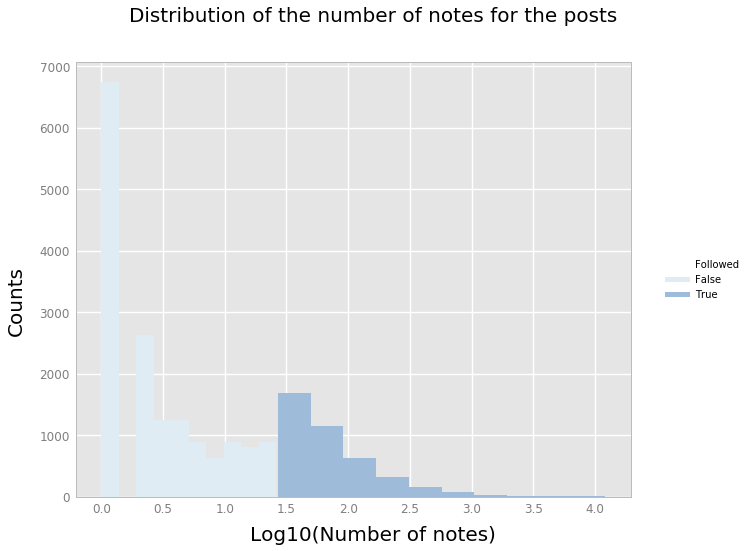

<ggplot: (8781050467953)>

In [8]:
import ggplot 
from ggplot import *

ggplot(aes(x='note_countlog',fill='Followed'), data=ststyle) +geom_histogram() \
+ theme(axis_title_x=element_text(size=20,text='Log10(Number of notes)'),\
        axis_title_y=element_text(size=20,text='Counts'),\
        plot_title=element_text(size=20,text="Distribution of the number of notes for the posts"))+\
scale_fill_brewer(palette=3)


## Order logit / Multiclass classification



In [9]:
len(ststyle)

20000

In [10]:
import math

ststyle['normalnote']=ststyle['note_count'].transform(lambda x: (x-mu)/se)



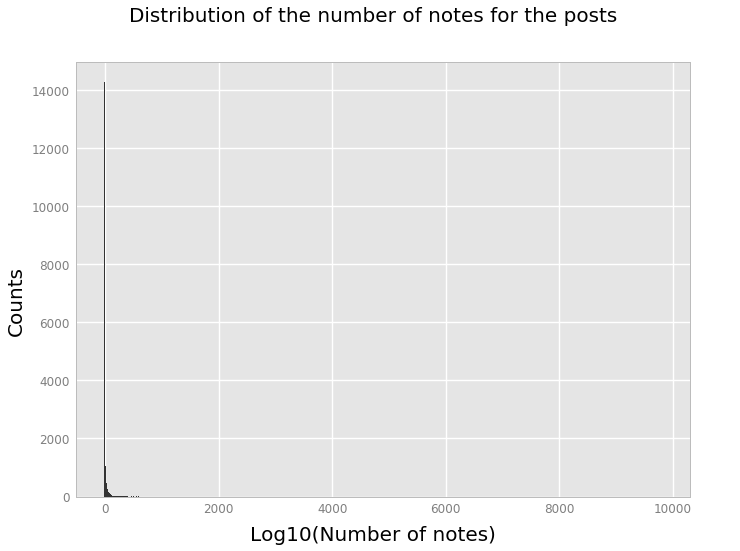

<ggplot: (8781036368109)>

In [11]:
ggplot(aes(x='normalnote'), data=ststyle) +geom_histogram(bins=1000) \
+ theme(axis_title_x=element_text(size=20,text='Log10(Number of notes)'),\
        axis_title_y=element_text(size=20,text='Counts'),\
        plot_title=element_text(size=20,text="Distribution of the number of notes for the posts"))+\
scale_fill_brewer(palette=3)

In [12]:
print len(ststyle)
print max(ststyle['note_count'])
#print 27824./83283  #for all files
#print 30964./83283
#print 24495./83283


20000
12101


In [13]:
cuta=ststyle['note_count'].quantile(q=.4)
cutb=ststyle['note_count'].quantile(q=.7)


print [cuta,cutb]


print len(ststyle.loc[ststyle['note_count']<cuta])
print len(ststyle.loc[(cuta<=ststyle['note_count'])&(ststyle['note_count']<=cutb)])
print len(ststyle.loc[ststyle['note_count']>cutb])

[1.0, 11.0]
6735
7313
5952


In [14]:
ststyle['Popularity']=pd.cut(ststyle['note_count'], [0, 1, 11, np.inf], labels=['notfollowed','relfollowed','popular'])

ststyle['Popularity']=np.where(ststyle['note_count'] > 11, 'Popular', 
         (np.where(ststyle['note_count'] < 1, 'NotFollowed', 'Followed')))

In [15]:
ststyle.head()

,Unnamed: 0,id,num_photos,photo_ratio,words,wcount,taglist,cphotos,blog_name,date,note_count,short_url,source_title,photoset_layout,note_countlog,Followed,normalnote,Popularity
0,0,165302423034,1,0.66640625,rick owen cargo basketsjoin clvn,6,"""street photography "",""streetwear "",""grailed ""...","""street photography "",""streetwear "",""grailed ""...",blvckclvn,2017-09-13 18:40:11 GMT,0,https://tmblr.co/ZgVDrv2Pyoitw,,,0.0,False,-23.523184,NotFollowed
1,1,165302400873,1,1.24921875,NaN,0,"""fashion lookbook "",""look day "",""lookofday "",""...","""fashion lookbook "",""look day "",""lookofday "",""...",dollmemories,2017-09-13 18:39:20 GMT,0,https://tmblr.co/ZC-mxw2PyodTf,,,0.0,False,-23.523184,NotFollowed
2,2,165302334049,1,0.66640625,rick owen geobasketsjoin clvn,5,"""grailed "",""street fashion "",""street style "",""...","""grailed "",""street fashion "",""street style "",""...",blvckclvn,2017-09-13 18:36:44 GMT,0,https://tmblr.co/ZgVDrv2PyoN9X,,,0.0,False,-23.523184,NotFollowed
3,3,165302193174,1,1.25,secret happiness human connection quote catgra...,36,"""ndaylensgratefulheart "",""travel "",""streetstyl...","""ndaylensgratefulheart "",""travel "",""streetstyl...",ndaylens,2017-09-13 18:31:16 GMT,0,https://tmblr.co/ZP4F6q2PynqmM,,,0.0,False,-23.523184,NotFollowed
4,4,165302121441,1,0.75,gagdrawings lover kiss art streetart streetsty...,24,"""woman "",""portrait "",""photooftheday "",""artlove...","""woman "",""portrait "",""photooftheday "",""artlove...",gagdrawings,2017-09-13 18:28:42 GMT,0,https://tmblr.co/ZbLLOo2PynZFX,,,0.0,False,-23.523184,NotFollowed


## Transformations for plotting correlations

In [16]:
set(ststyle['photoset_layout'])
s=set(ststyle['photoset_layout'])
dic={s:i for i, s in enumerate(set(ststyle['photoset_layout']))}
ststyle=ststyle.replace({'photoset_layout': dic})
ststyle['photoset_layout'] =ststyle['photoset_layout'].apply(str)

In [17]:
from ggplot import *
import math

#type(streetstyle)
#streetstyle[['note_count']]=streetstyle[['note_count']].astype(float)
#list(ststyle)
#['Unnamed: 0','id','num_photos','photo_ratio','words','wcount','taglist','cphotos','blog_name','date','note_count','short_url','source_title','photoset_layout','Followed']

ststyle['note_countlog']=ststyle['note_count'].transform(lambda x: math.log10(x+1))
ststyle['num_photos']=ststyle['num_photos'].astype(float)
ststyle['wcount']=ststyle['wcount'].astype(float)
ststyle['photo_ratio']=pd.to_numeric(ststyle['photo_ratio'], errors='coerce')
ststyle['hour']=[pd.to_datetime(item).hour for item in ststyle['date']]
ststyle['Date_']=pd.to_datetime(ststyle['date'])
#ststyle['Date_']=[pd.to_datetime(item) for item in ststyle['date']]
ststyle_sort=ststyle.sort_values(by='Date_',ascending=False)

In [18]:

ststyle_sort.shape
ststyle.iloc[10000]
(ststyle_sort['Date_'].iloc[0]-ststyle_sort['Date_'].iloc[-1])

Timedelta('577 days 08:49:02')

In [19]:
ststyle.info()
len(set(ststyle['Date_']))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 9999
Data columns (total 20 columns):
Unnamed: 0         20000 non-null int64
id                 20000 non-null int64
num_photos         20000 non-null float64
photo_ratio        19532 non-null float64
words              14156 non-null object
wcount             20000 non-null float64
taglist            20000 non-null object
cphotos            20000 non-null object
blog_name          20000 non-null object
date               20000 non-null object
note_count         20000 non-null int64
short_url          20000 non-null object
source_title       20000 non-null object
photoset_layout    20000 non-null object
note_countlog      20000 non-null float64
Followed           20000 non-null bool
normalnote         20000 non-null float64
Popularity         20000 non-null object
hour               20000 non-null int64
Date_              20000 non-null datetime64[ns]
dtypes: bool(1), datetime64[ns](1), float64(5), int64(4), object(

19129

In [20]:
ststyle['photo_ratio'].isnull().sum()

468

## Correlations

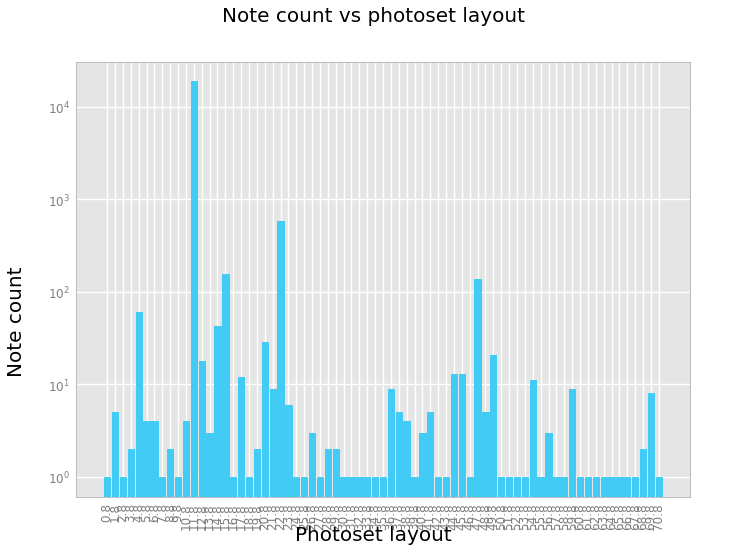

<ggplot: (8781036249457)>

In [21]:
ggplot(aes(x='photoset_layout',y='note_countlog'), data=ststyle) +geom_bar(fill='#42cbf4') \
+theme(axis_title_x=element_text(size=20,text='Photoset layout'),\
axis_title_y=element_text(size=20,text='Note count'),\
plot_title=element_text(size=20,text="Note count vs photoset layout"),axis_text_x=element_text(angle=90))+\
scale_y_log(base=10)

In [22]:
ststyle.loc[0,:]

,Unnamed: 0,id,num_photos,photo_ratio,words,wcount,taglist,cphotos,blog_name,date,note_count,short_url,source_title,photoset_layout,note_countlog,Followed,normalnote,Popularity,hour,Date_
0,0,165302423034,1.0,0.666406,rick owen cargo basketsjoin clvn,6.0,"""street photography "",""streetwear "",""grailed ""...","""street photography "",""streetwear "",""grailed ""...",blvckclvn,2017-09-13 18:40:11 GMT,0,https://tmblr.co/ZgVDrv2Pyoitw,,19,0.000000,False,-23.523184,NotFollowed,18,2017-09-13 18:40:11
0,0,165287799093,1.0,1.500000,like,3.0,"""yasmin sewell "",""fashion "",""street style "",""s...","""yasmin sewell "",""fashion "",""street style "",""s...",15x20,2017-09-13 06:53:03 GMT,2,https://tmblr.co/Z0VQ-t2Pxwwar,15x20,19,0.477121,False,-21.897299,Followed,6,2017-09-13 06:53:03


In [23]:
# 0.477121, 6

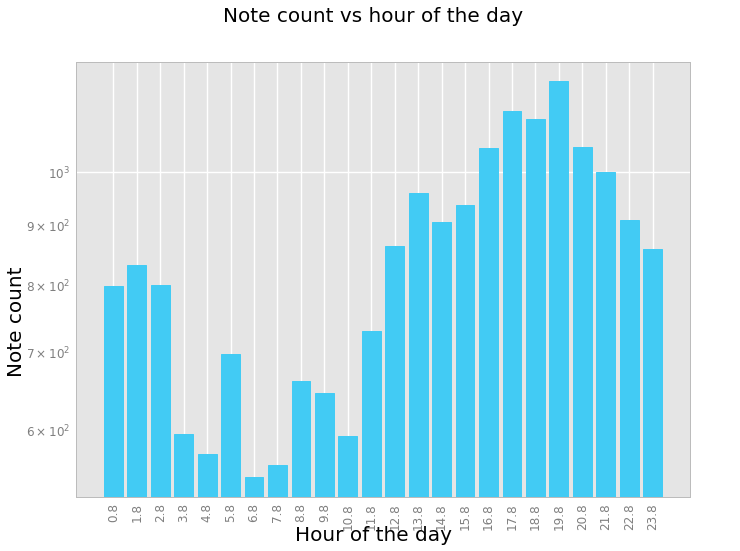

<ggplot: (8781036127585)>

In [24]:
dataText=pd.DataFrame.from_items([('x',[6]),('y',[.477121]),('text',['User'])])

ggplot(aes(x='hour',y='note_countlog'), data=ststyle) +geom_bar(fill='#42cbf4') \
+theme(axis_title_x=element_text(size=20,text='Hour of the day'),\
axis_title_y=element_text(size=20,text='Note count'),\
plot_title=element_text(size=20,text="Note count vs hour of the day"),axis_text_x=element_text(angle=90))+\
scale_y_log(base=10)#+ geom_text(aes(x='hour', y='note_countlog', label='text'), data=dataText)

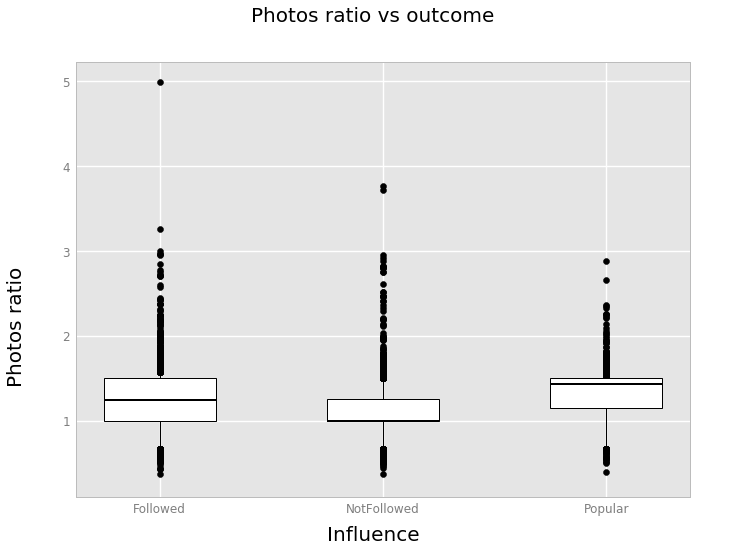

<ggplot: (8781031917289)>

In [25]:
ggplot(aes(x='Popularity',y='photo_ratio'), data=ststyle) +geom_boxplot(fill='#14A7CB') \
+ theme(axis_title_x=element_text(size=20,text='Influence'),\
        axis_title_y=element_text(size=20,text='Photos ratio'),\
        plot_title=element_text(size=20,text="Photos ratio vs outcome"))

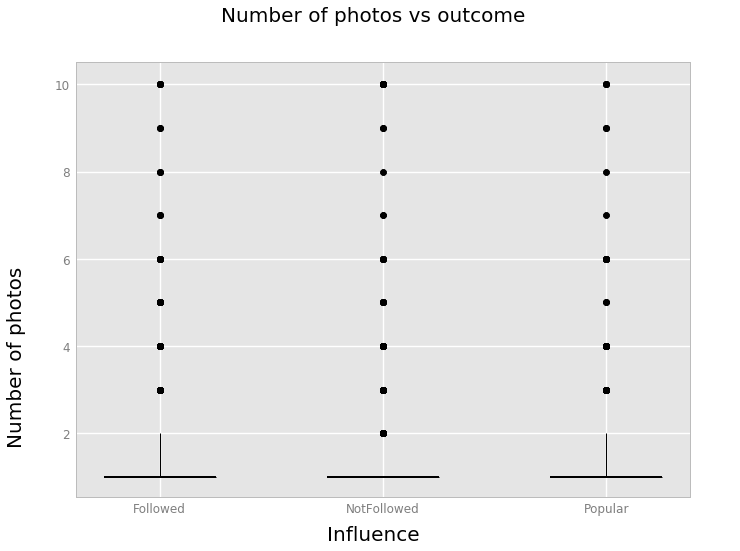

<ggplot: (8781030644093)>

In [26]:
ggplot(aes(x='Popularity',y='num_photos'), data=ststyle) +geom_boxplot(fill='#14A7CB') \
+ theme(axis_title_x=element_text(size=20,text='Influence'),\
        axis_title_y=element_text(size=20,text='Number of photos'),\
        plot_title=element_text(size=20,text="Number of photos vs outcome"))

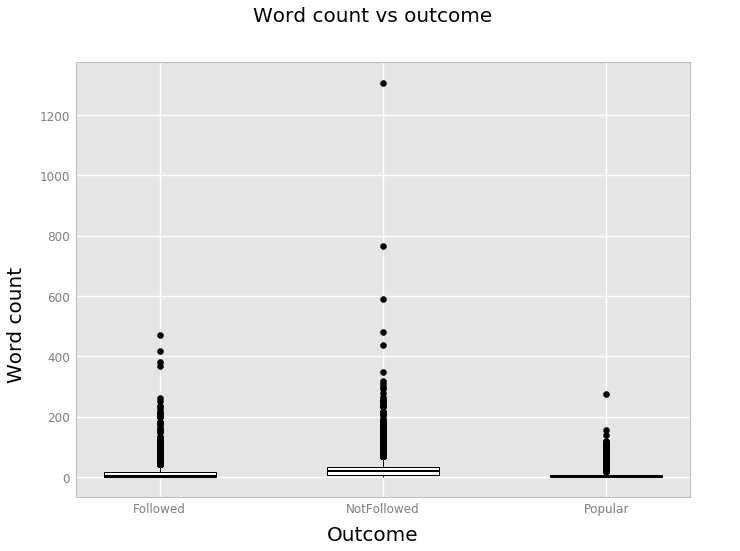

<ggplot: (8781030600773)>

In [27]:
ggplot(aes(x='Popularity',y='wcount',fill='num_photos'), data=ststyle) +geom_boxplot(col='#14A7CB') \
+ theme(axis_title_x=element_text(size=20,text='Outcome'),\
        axis_title_y=element_text(size=20,text='Word count'),\
        plot_title=element_text(size=20,text="Word count vs outcome"))

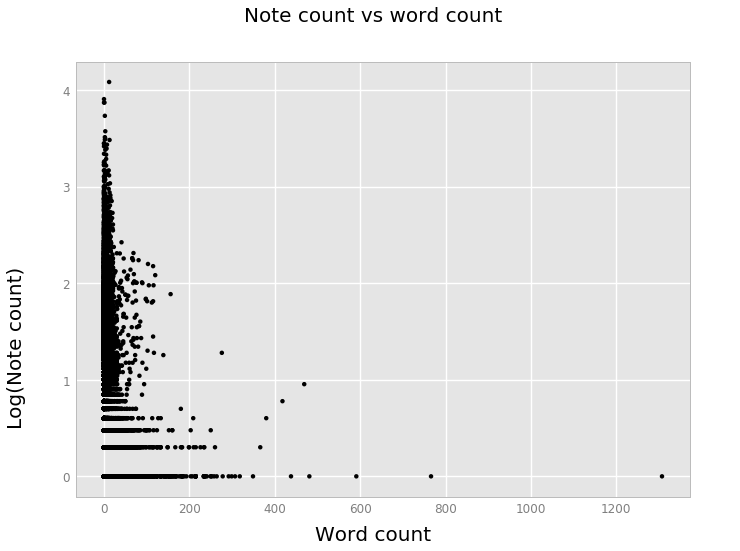

<ggplot: (8781031146465)>

In [28]:
ggplot(aes(x='wcount',y='note_countlog'), data=ststyle) +geom_point(col='#14A7CB') \
+ theme(axis_title_x=element_text(size=20,text='Word count'),\
        axis_title_y=element_text(size=20,text='Log(Note count)'),\
        plot_title=element_text(size=20,text="Note count vs word count"))

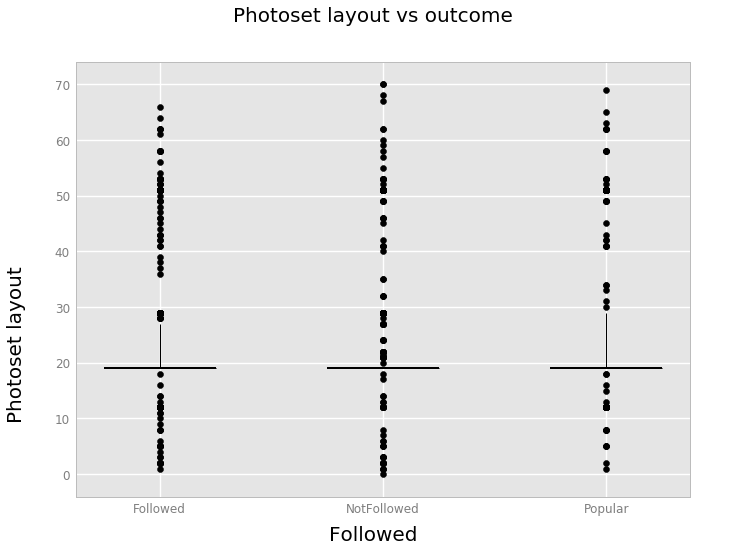

<ggplot: (8781036196409)>


In [29]:
from ggplot import *

ststyle['photoset_layout_n']=ststyle['photoset_layout'].astype('int')

p=ggplot(aes(x='Popularity',y='photoset_layout_n'), data=ststyle) +geom_boxplot() 
p+= theme(axis_title_x=element_text(size=20,text='Followed'),\
        axis_title_y=element_text(size=20,text='Photoset layout'),\
        plot_title=element_text(size=20,text="Photoset layout vs outcome"))
print ( p+ scale_fill_brewer(palette='Blues') )

```
#list(ststyle)
#['Unnamed: 0','id','num_photos','photo_ratio','words','wcount','taglist','cphotos','blog_name','date','note_count','short_url','source_title','photoset_layout','Followed']
```
### Interesting features: 
1. Gather in a handful of users (most frequent) + other
2. Gather in a handful of tags? (most frequent) +other  This could be interesting, could impact brand marketing



## Feature engineering (other than former transformations)

### Frequent bloggers

In [30]:
frq_blogs=pd.DataFrame(ststyle['blog_name'].value_counts())  
len(frq_blogs)
### I have to revise if the frequent users posts are produced each in a single day!!!!!!!!!!!!!!!!!!! 

3810

In [31]:
frq_blogs['names'] = frq_blogs.index
frq_blogs=frq_blogs.rename(index=str, columns={"blog_name": "Frequency", "names": "names"})
print frq_blogs['Frequency'].mean()
list(frq_blogs)
frq_blogs.info()
thresh=frq_blogs.quantile(q=.6)[0]
print thresh

5.24934383202
<class 'pandas.core.frame.DataFrame'>
Index: 3810 entries, mensstreet to okay--princess
Data columns (total 2 columns):
Frequency    3810 non-null int64
names        3810 non-null object
dtypes: int64(1), object(1)
memory usage: 89.3+ KB
2.0



So around 80 % of bloggers have less than 3 posts in this period of time.

I will asume that any user blog with more than 'thresh' is frequent.


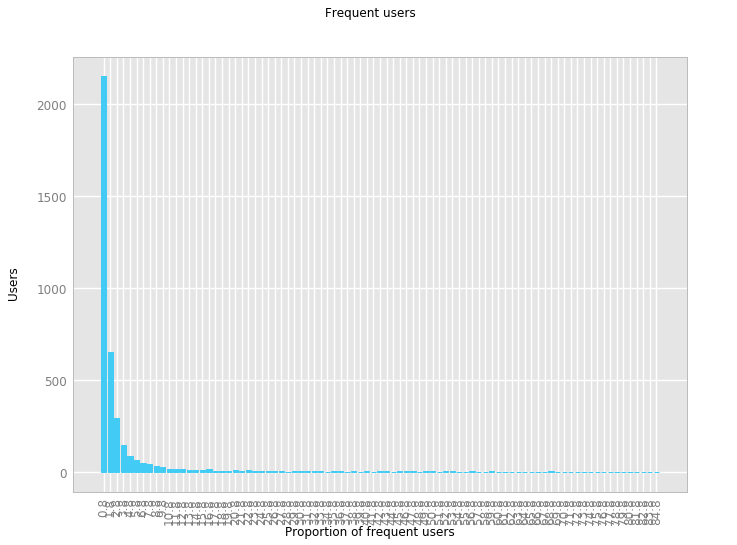

<ggplot: (8781035953777)>

In [32]:
ggplot(frq_blogs,aes(x='Frequency'))+geom_bar(fill='#42cbf4')+\
theme(axis_text_x = element_text( angle=90))+\
labs(x="Proportion of frequent users",y="Users",title="Frequent users")

In [33]:
df_freq=frq_blogs[frq_blogs['Frequency']>thresh]
list(df_freq)
#df_freq['names'].tolist()

['Frequency', 'names']

In [34]:
len(df_freq)
isfreq=ststyle['blog_name'].isin(df_freq['names'].tolist())
#ststylefreq=ststyle[ststyle['blog_name'].isin(df_freq['names'].tolist()),]
#ststylenfreq=stsyle[~ststyle['blog_name']%in% df_freq['names'],]

ststyle['isfreq']=isfreq.astype(int)
#frequency for each blog_name, I will have to 

In [35]:
ststyle['isfreq'].sum()

16549L

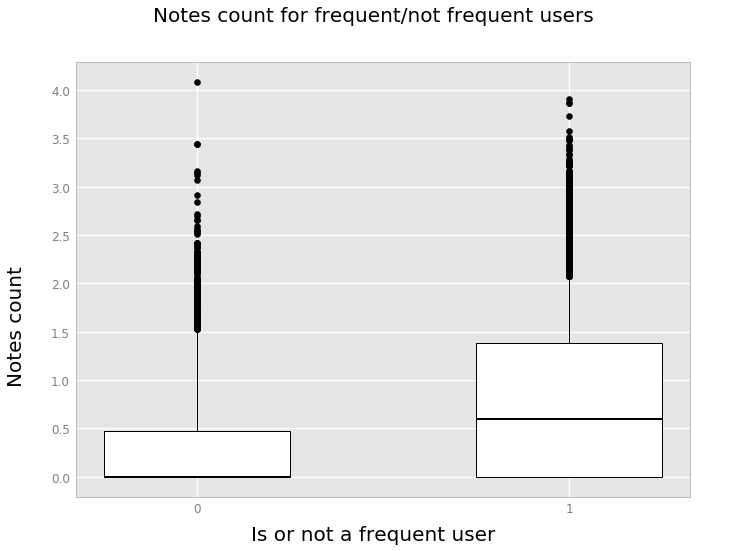

<ggplot: (8781030184629)>


In [36]:
p=ggplot(aes(x='isfreq',y='note_countlog'), data=ststyle) +geom_boxplot() 
p+= theme(axis_title_x=element_text(size=20,text='Is or not a frequent user'),\
        axis_title_y=element_text(size=20,text='Notes count'),\
        plot_title=element_text(size=20,text="Notes count for frequent/not frequent users"))
print ( p+ scale_fill_brewer(palette='Blues') )

### Layouts

In [37]:
frq_layouts=pd.DataFrame(ststyle['photoset_layout'].value_counts())  
len(frq_layouts)
### I have to revise if the frequent users posts are produced each in a single day!!!!!!!!!!!!!!!!!!! 

71

In [38]:
frq_layouts['layouts'] = frq_layouts.index
frq_layouts=frq_layouts.rename(index=str, columns={"photoset_layout": "Frequency", "layouts": "layouts"})
print frq_layouts['Frequency'].mean()
print list(frq_layouts)
threshl=frq_blogs.quantile(q=.5)[0]
print threshl
frq_layouts.head()

281.690140845
['Frequency', 'layouts']
1.0


,Frequency,layouts
19,18760,19
29,589,29
22,155,22
51,139,51
12,61,12


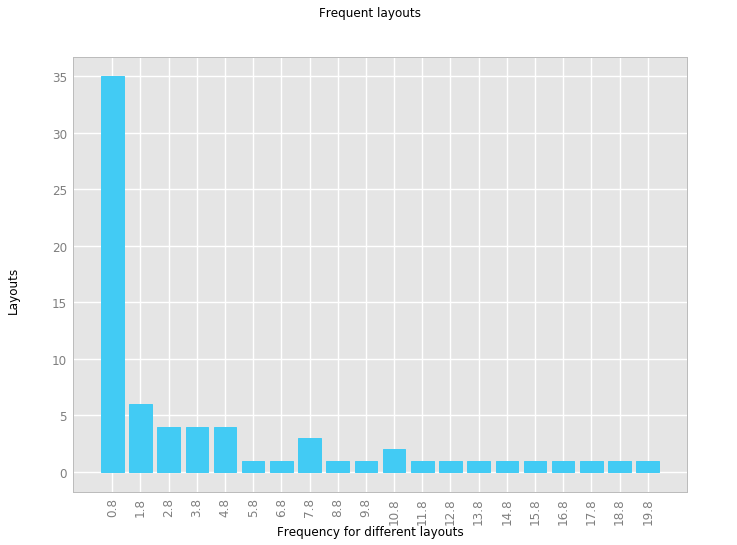

<ggplot: (8781030114185)>

In [39]:
ggplot(frq_layouts,aes(x='Frequency'))+geom_bar(fill='#42cbf4')+\
theme(axis_text_x = element_text( angle=90))+\
labs(x="Frequency for different layouts",y="Layouts",title="Frequent layouts")

In [40]:
lay_freq=frq_layouts[frq_layouts['Frequency']>threshl]
list(lay_freq)
#df_freq['names'].tolist()
len(lay_freq)
frq_layouts[frq_layouts['Frequency']>threshl].to_csv('freq_layout')


In [41]:

isfreql=ststyle['photoset_layout'].isin(lay_freq['layouts'].tolist())
#ststylefreq=ststyle[ststyle['blog_name'].isin(df_freq['names'].tolist()),]
#ststylenfreq=stsyle[~ststyle['blog_name']%in% df_freq['names'],]

ststyle['isfreql']=isfreql.astype(int)
#frequency for each blog_name, I will have to 

In [42]:
ststyle['aspect_ratio']=[1/item for item in ststyle['photo_ratio']]

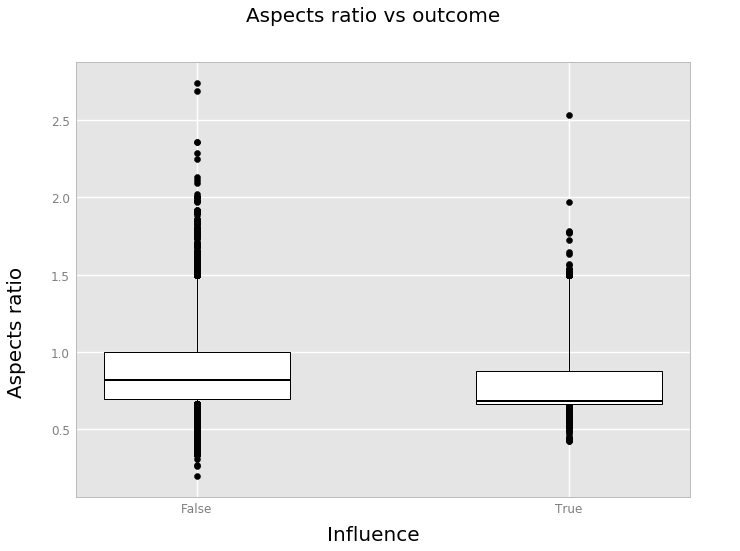

<ggplot: (8781030110897)>

In [43]:
import ggplot
from ggplot import *

ggplot(aes(x='Followed',y='aspect_ratio'), data=ststyle) +geom_boxplot(fill='#14A7CB') \
+ theme(axis_title_x=element_text(size=20,text='Influence'),\
        axis_title_y=element_text(size=20,text='Aspects ratio'),\
        plot_title=element_text(size=20,text="Aspects ratio vs outcome"))

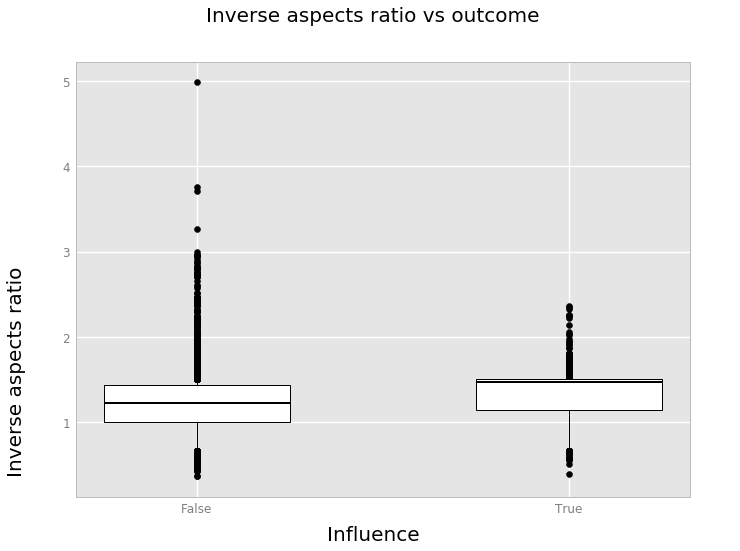

<ggplot: (8781029999333)>

In [44]:
import ggplot
from ggplot import *

ggplot(aes(x='Followed',y='photo_ratio'), data=ststyle) +geom_boxplot(fill='#14A7CB') \
+ theme(axis_title_x=element_text(size=20,text='Influence'),\
        axis_title_y=element_text(size=20,text='Inverse aspects ratio'),\
        plot_title=element_text(size=20,text="Inverse aspects ratio vs outcome"))

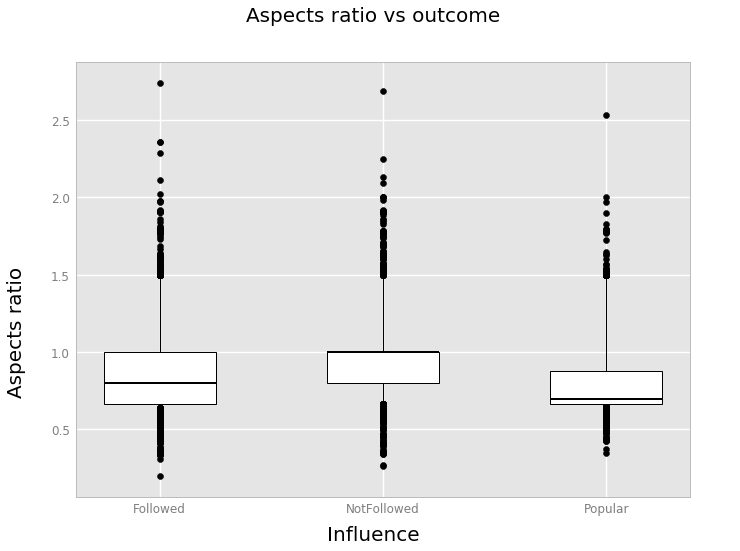

<ggplot: (8781029924221)>

In [45]:
import ggplot
from ggplot import *

ggplot(aes(x='Popularity',y='aspect_ratio'), data=ststyle) +geom_boxplot(fill='#14A7CB') \
+ theme(axis_title_x=element_text(size=20,text='Influence'),\
        axis_title_y=element_text(size=20,text='Aspects ratio'),\
        plot_title=element_text(size=20,text="Aspects ratio vs outcome"))

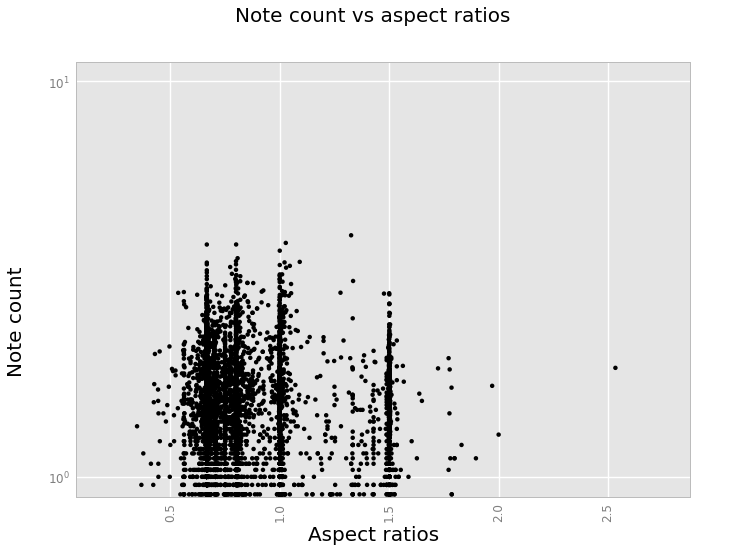

<ggplot: (8781030167077)>

In [46]:
ggplot(aes(x='aspect_ratio',y='note_countlog'), data=ststyle) +geom_point(fill='#42cbf4') \
+theme(axis_title_x=element_text(size=20,text='Aspect ratios'),\
axis_title_y=element_text(size=20,text='Note count'),\
plot_title=element_text(size=20,text="Note count vs aspect ratios"),axis_text_x=element_text(angle=90))+\
scale_y_log(base=10)

In [47]:
pop=ststyle['id'].loc[(ststyle['Popularity']=='Popular')]
sampleid_pop=np.random.choice(pop, 10,replace=False)

In [48]:
sampleid_pop

array([163952580470, 165017326834, 164534437686, 164273118589,
       164599786593, 164604982276, 163855745583, 163961694224,
       163649587814, 164048606728])

In [49]:
ststyle['short_url'][ststyle['id'].isin(sampleid_pop)]

5017    https://tmblr.co/ZBboqp2PIwMnX
8660    https://tmblr.co/ZBboqp2Oo3nO8
1883    https://tmblr.co/ZR-n4t2Php9Jo
4341    https://tmblr.co/Z6aQKy2PJEBG4
4384    https://tmblr.co/ZBboqp2PIwMnX
4751    https://tmblr.co/ZHgsde2PF14Ss
6064    https://tmblr.co/ZlzZ7x2O-SDrz
7281    https://tmblr.co/ZBboqp2Oo3nO8
7768    https://tmblr.co/Z3nr6x2OiuEWG
7812    https://tmblr.co/Zt3kxu2OiLTTs
8282    https://tmblr.co/ZeWKTx2Oca48l
9385    https://tmblr.co/ZRUISv2OQHefc
Name: short_url, dtype: object

In [56]:
npop=ststyle['id'].loc[(ststyle['Popularity']=='NotFollowed')]
sampleid_npop=np.random.choice(npop, 10,replace=False)

In [57]:
sampleid_npop

array([164402713279, 163894895499, 164440519522, 165294679874,
       163990050373, 165118588887, 164618249593, 164640093888,
       165224468969, 164326679350])

In [58]:
ststyle['short_url'][ststyle['id'].isin(sampleid_npop)]

110     https://tmblr.co/Zhhm7i2PyLAT2
701     https://tmblr.co/ZS8ylr2Pu9L7f
4881    https://tmblr.co/ZNdVSi2PK0oLv
6120    https://tmblr.co/Z-yx8m2P9QpDY
6336    https://tmblr.co/Zn25gs2P7AbA-
6787    https://tmblr.co/Zy-LDq2P2eYCs
9012    https://tmblr.co/ZhoE7t2OkaPP5
9668    https://tmblr.co/ZVPd4s2OevQEB
1258    https://tmblr.co/Zuhzti2PnrRVN
4111    https://tmblr.co/ZpF5aj2PLK7R0
Name: short_url, dtype: object

## Tags and words

In [45]:
import fuzzywuzzy 
from fuzzywuzzy import fuzz
from nltk.stem import WordNetLemmatizer

#tags.iloc[0]
#compare one by one, if prob is greater than 70 

fuzz.token_sort_ratio("alexa","alexa chung")

63

In [46]:
ststyle['taglist'].isnull().sum()

0

In [47]:
import re
import fuzzywuzzy 
from fuzzywuzzy import fuzz
import operator

def tagextractor(taglist,N):
    '''Extracts the top N frequent words from the taglist column of the posts dataframe
    where each row is a set of tags such like: ' "street style","streetstyle","fashion" '
    '''
    #N number of top repeated words
    
    array_tags=[]
#nested list size 20000
    for i,row in enumerate(taglist):
        r=[]
        if not pd.isnull(row):
            s=re.findall(r'"[a-zA-Z\s]*"',row)
            for item in s:
                r.append(re.sub(r'[^a-zA-Z ]','',item))
            array_tags.append(r)
        else:
            array_tags.append('')
#flatten and clean list to search for most frequent
    flatten_tags=[]
    for i,row in enumerate(taglist):
        if not pd.isnull(row):
            s=re.findall(r'"[a-zA-Z\s]*"',row)
            for item in s:
                flatten_tags.append(re.sub(r'[^a-zA-Z ]','',item))
        else:
            flatten_tags.append('')
    # remove the tags I used to find the posts
    flatten=[w for w in flatten_tags if re.search(r'street',w)is None \
             and re.search(r'fashion',w)is None \
             and re.search(r'style',w) is None\
            and re.search(r'fashion',w)is None \
             and re.search(r'wear',w) is None\
             and re.search(r'moda',w) is None\
            and re.search(r'cloth',w) is None\
            and re.search(r'men',w) is None\
            and re.search(r'outfit',w) is None\
             and re.search(r'ootd',w) is None\
            and re.search(r'man',w) is None\
            and re.search(r'male',w) is None\
            and re.search(r'girl',w) is None\
            and re.search(r'woman',w) is None\
            and re.search(r'curvy',w) is None]
    flatten.remove('')
     #streetstyle,street_style,mens_wear,menswear,mensfashion,mensfashion,fashion,high_fashion
    ## find similar misspelled words and drop similars before counting
    ## fuzz.token_set_ratio(x,y) compares x and y and gives probability of similarity,
    # >65 are probably the same Proper nouns
        
        
    word_counter = {}
    for word in flatten:
        if word in word_counter:
            word_counter[word] += 1
        else:
            word_counter[word] = 1
    del word_counter['']
    popular_words = sorted(word_counter, key = word_counter.get, reverse = True)
    popular_freq=sorted(word_counter.items(), key=operator.itemgetter(1),reverse=True) 
    top = popular_words[:N]
    
    return array_tags,top,flatten

def wordextractor(wordlist,N):

    words_list=[row.split() for row in wordlist]
    flatten_words=[item for sublist in words_list for item in sublist]
    flatten=[w for w in flatten_words if re.search(r'street.',w)is None\
             and re.search(r'fashion.',w)is None\
             and re.search(r'style.',w) is None \
             and re.search(r'womenswear. ',w) is None\
            and re.search(r'menswear. ',w) is None]        
  
    word_counter = {}
    for word in flatten:
        if word in word_counter:
            word_counter[word] += 1
        else:
            word_counter[word] = 1
    popular_words = sorted(word_counter, key = word_counter.get, reverse = True)
    popular_freq=sorted(word_counter.items(), key=operator.itemgetter(1),reverse=True) 
    top = popular_words[:N]
    
    return words_list,top,flatten



In [48]:
array_tags,topN,ftags=tagextractor(ststyle['taglist'],200)
array_word,topNw,fword=wordextractor(ststyle['words'].fillna(''),200)

In [49]:
topN

['model ',
 'stylish ',
 'love ',
 'model duty ',
 'swag ',
 'photography ',
 'instagood ',
 'nyfw ',
 'trend ',
 'celebs ',
 'urban ',
 'hypebeast ',
 'blogger ',
 'lookbook ',
 'beautiful ',
 'shoe ',
 'art ',
 'summer ',
 'apparel ',
 'grunge ',
 'nyc ',
 'photooftheday ',
 'candids ',
 'follow ',
 'beauty ',
 'photo ',
 'dope ',
 'cute ',
 'hipster ',
 'design ',
 's ',
 'picoftheday ',
 'indie ',
 'look ',
 'candid ',
 'paris ',
 'sexy ',
 'fresh ',
 'inspiration ',
 'denim ',
 'hot ',
 'kick ',
 'hair ',
 'vintage ',
 'newyork ',
 'gear ',
 'famous ',
 'luxury ',
 'black ',
 'travel ',
 'casual ',
 'lookoftheday ',
 'life ',
 'dress ',
 'hiphop ',
 'sneaker ',
 'instagram ',
 'likelike ',
 'adidas ',
 'instadaily ',
 'music ',
 'london ',
 'supreme ',
 'duty ',
 'designer ',
 'pfw ',
 'portrait ',
 'makeup ',
 'followme ',
 'kendall jenner ',
 'victoria secret ',
 'nike ',
 'actress ',
 'photoshoot ',
 'stylist ',
 'bella hadid ',
 'jean ',
 'trendy ',
 'august ',
 'graffiti ',
 

In [50]:
len(ststyle)

20000

### Creating a variable defined as: number of tags in each row that belong to the topN

In [51]:
#topN
#array_tags
#number of times any tag appears in set topN

freq_tags=[]
count=0
for tags in array_tags:
    count=0
    for tag in tags:
        if tag in topN:
            count+=1
    freq_tags.append(count)

ststyle['freq_tags']=freq_tags

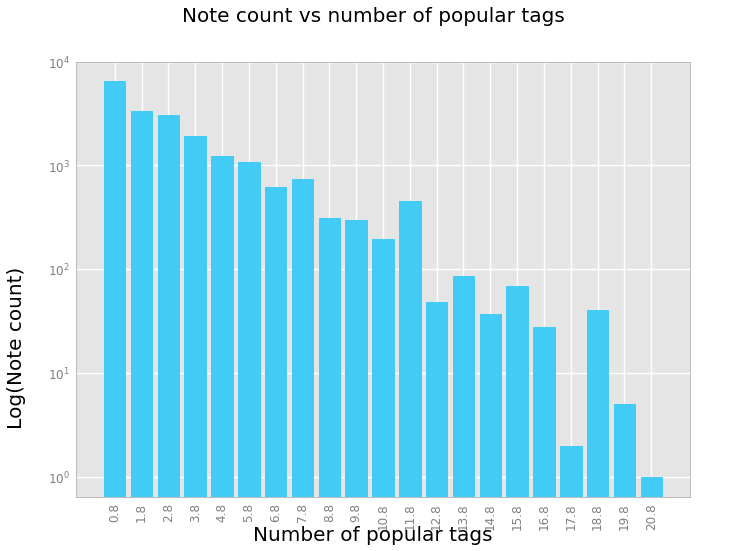

<ggplot: (8777876119661)>

In [52]:
import ggplot
from ggplot import *


ggplot(aes(x='freq_tags',y='note_countlog'), data=ststyle) +geom_bar(fill='#42cbf4') \
+theme(axis_title_x=element_text(size=20,text='Number of popular tags'),\
axis_title_y=element_text(size=20,text='Log(Note count)'),\
plot_title=element_text(size=20,text="Note count vs number of popular tags"),axis_text_x=element_text(angle=90))+\
scale_y_log(base=10)

### Building training data

In [53]:
ststyle.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 9999
Data columns (total 25 columns):
Unnamed: 0           20000 non-null int64
id                   20000 non-null int64
num_photos           20000 non-null float64
photo_ratio          19532 non-null float64
words                14156 non-null object
wcount               20000 non-null float64
taglist              20000 non-null object
cphotos              20000 non-null object
blog_name            20000 non-null object
date                 20000 non-null object
note_count           20000 non-null int64
short_url            20000 non-null object
source_title         20000 non-null object
photoset_layout      20000 non-null object
note_countlog        20000 non-null float64
Followed             20000 non-null bool
normalnote           20000 non-null float64
Popularity           20000 non-null object
hour                 20000 non-null int64
Date_                20000 non-null datetime64[ns]
photoset_layout_n    2000

```
set.seed(123)
train<-df_pre[,-2]
intrain <- createDataPartition(train$visitor, p = 0.7, list=FALSE)#training and testing
mod_train <- train[intrain, ]
mod_test <- train[-intrain, ]

test<-df_prev[,-1]
```

In [55]:
writetofile=ststyle.loc[:,['note_countlog','wcount','hour','aspect_ratio','freq_tags','Popularity']]
writetofile.to_csv('data.csv')

## Machine learning algorithm

#### Partitioning the dataset: train and  validation: (80: 80/20), test 20


In [54]:
import sklearn
import random
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

#from sklearn.tree import DecisionTreeClassifier



random.seed(123)

#Partitioning by hand 
#x = numpy.random.rand(100, 5)
#indices = numpy.random.permutation(x.shape[0])
#training_idx, test_idx = indices[:80], indices[80:]
#training, test = x[training_idx,:], x[test_idx,:]


X = ststyle.loc[:,['num_photos','aspect_ratio','wcount','hour','freq_tags','isfreq','isfreql']]
y = ststyle.loc[:,'Followed']
X['aspect_ratio'] = X['aspect_ratio'].fillna(X['aspect_ratio'].mean())

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)

#[X[x].isnull().sum() for x in list(x_train)] #Making sure with don't have na's

#For such a small proportion of na's 460/20000 it's reasonable to replace with the mean




/home/vanniagm/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [55]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 9999
Data columns (total 7 columns):
num_photos      20000 non-null float64
aspect_ratio    20000 non-null float64
wcount          20000 non-null float64
hour            20000 non-null int64
freq_tags       20000 non-null int64
isfreq          20000 non-null int64
isfreql         20000 non-null int64
dtypes: float64(3), int64(4)
memory usage: 1.8 MB


In [244]:
random.seed(123)

logistic = LogisticRegression(C=1e3)
logistic.fit(x_train, y_train)
logistic.predict(x_val)

array([False, False, False, ..., False, False, False], dtype=bool)

In [245]:
logistic.score(x_val,y_val)

0.80340990954934766

In [246]:
sklearn.metrics.confusion_matrix(y_val,logistic.predict(x_val))
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_val,logistic.predict(x_val)).ravel()

acc=(tp+tn*1.)/(tn+tp+fn+fp)
print acc
print (tn, fp, fn, tp)

0.803409909549
(10036, 1, 2455, 1)


In [247]:

models=[]
models.append(('LR',LogisticRegression()))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('KNN',KNeighborsClassifier()))
#models.append(('DTC',DecisionTreeClassifier()))
models.append(('RFC',RandomForestClassifier(n_estimators=20)))
#models.append(('SVM',SVC()))

print 'Accuracy for each algorithm'

results=[]
names=[]
scoring='accuracy'

for name,model in models:
    kfold=RepeatedKFold(n_splits=5,n_repeats=3,random_state=123)
    cv_results=cross_val_score(model,x_train,y_train,cv=kfold,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    mod=model
    mod.fit(x_train,y_train)
    mod_pred=mod.predict(x_val)
    mod_accuracy=accuracy_score(mod_pred,y_val)
    msg='CV accuracy %s:, %f SD %f - Validation  accuracy: %f ' % (name, cv_results.mean(),cv_results.std(),mod_accuracy)
    print(msg)




Accuracy for each algorithm
CV accuracy LR:, 0.795865 SD 0.004272 - Validation  accuracy: 0.803410 
CV accuracy LDA:, 0.795876 SD 0.004267 - Validation  accuracy: 0.803410 
CV accuracy KNN:, 0.809713 SD 0.003250 - Validation  accuracy: 0.820940 
CV accuracy RFC:, 0.840755 SD 0.003189 - Validation  accuracy: 0.848075 


In [280]:
random.seed(123)
#kfold=RepeatedKFold(n_splits=5,n_repeats=3,random_state=123)
rfmodel=RandomForestClassifier(n_estimators=20)
rfmodel.fit(x_train,y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [281]:
pred=rfmodel.predict(x_test)
tn, fp, fn, tp = confusion_matrix(y_test,pred).ravel()

acc=(tp+tn*1.)/(tn+tp+fn+fp)
print acc
print (tn, fp, fn, tp)

0.846942042907
(9261, 678, 1234, 1319)


In [288]:
from sklearn.externals import joblib
joblib.dump(rfmodel, 'rfmodel_ststyle.pkl') 

['rfmodel_ststyle.pkl']

In [283]:
random.seed(123)

#y_score = svmodel.fit(x_train, y_train).decision_function(x_test)
#fpr = dict()
#tpr = dict()
#roc_auc = dict()

#fpr, tpr, thresh = roc_curve(y_test, y_score)
#roc_auc = auc(fpr, tpr)
#rocpoints=pd.DataFrame(np.transpose([fpr, tpr, thresh,tpr/fpr]))

pred_prob=rfmodel.predict_proba(x_test)[:, 1]
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, thresh = roc_curve(y_test, pred_prob)
roc_auc = auc(fpr, tpr)


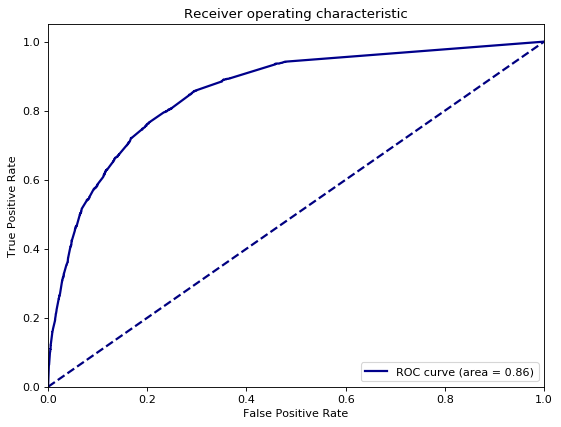

In [284]:
import matplotlib.pyplot as plt

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
lw = 2
plt.plot(fpr, tpr, color='darkblue',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('roc.png')

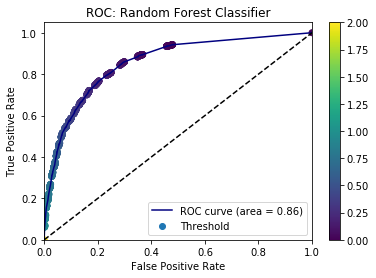

In [285]:

plt.plot(fpr, tpr, color='navy', label='ROC curve (area = %0.2f)' % roc_auc)
plt.scatter(fpr, tpr, c=thresh, cmap='viridis', label='Threshold')
plt.colorbar()
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Random Forest Classifier')
plt.legend(loc="lower right")
plt.show()
plt.draw()


#### Classification accuracy is 83%
#### Null accuracy: accuracy that could be achieved by always predicting the most frequent class (Not followed)
#### We must always compare with this

In [286]:
print y_test.mean()

# calculate the percentage of zeros
print 1 - y_test.mean()

# calculate null accuracy in a single line of code
# only for binary classification problems coded as 0/1
print max(y_test.mean(), 1 - y_test.mean())

#This means that a dumb model that always predicts 0 would be right 80% of the time
#This shows how classification accuracy is not that good as it's close to a dumb model
#It's a good way to know the minimum we should achieve with our models

0.20437079731
0.79562920269
0.79562920269


In [287]:
classification_error = (fp + fn) / float(tp + tn + fp + fn)

print(classification_error)
print(1 - accuracy_score(y_test, pred))

sensitivity = tp / float(fn + tp)
recall=sensitivity
print(sensitivity)
print(recall_score(y_test, pred))

specificity = tp / float(tn + fp)

print(specificity)

false_positive_rate = fp / float(tn + fp)

print(false_positive_rate)
print(1 - specificity)

precision = tp / float(tp + fp)

print(precision)
print(precision_score(y_test, pred))

f1score= 2*(precision*recall)/(precision+recall)
print f1score

0.153057957093
0.153057957093
0.516647081864
0.516647081864
0.132709528122
0.0682161183218
0.867290471878
0.660490736104
0.660490736104
0.57978021978


## Feature importance

Feature ranking:
1. feature 1 (0.375689)
2. feature 2 (0.335784)
3. feature 3 (0.121903)
4. feature 4 (0.116259)
5. feature 5 (0.032280)
6. feature 0 (0.017748)
7. feature 6 (0.000336)


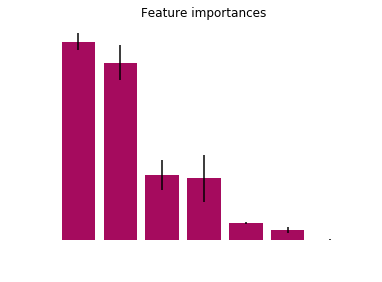

In [62]:
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(n_estimators=20,
                              random_state=123)

forest.fit(x_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()

font = {'family': 'sans-serif',
            'color':  'white',
            'weight': 'normal',
            'size': 28,
            }

plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color='#a50b5e', yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.suptitle('')
ax.set_title('')
ax = plt.gca()
labels=['AR','WC','H','T']
ax.set_xticklabels(labels,fontdict=font)

ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

plt.savefig('feature.png', transparent=True, bbox_inches='tight',dpi=800)
plt.show()

In [260]:
list(x_train)

['num_photos',
 'aspect_ratio',
 'wcount',
 'hour',
 'freq_tags',
 'isfreq',
 'isfreql']

best = threshold[5]
new_model = constructor(threshold=best)

# Machine learning Multiple classes 

In [261]:
cuta=ststyle['note_count'].quantile(q=.33)
cutb=ststyle['note_count'].quantile(q=.66)


print [cuta,cutb]

print len(ststyle.loc[ststyle['note_count']==cuta])
print len(ststyle.loc[(cuta<ststyle['note_count'])&(ststyle['note_count']<=cutb)])
print len(ststyle.loc[ststyle['note_count']>cutb])

[0.0, 7.0]
27824
27155
28304


In [262]:

ststyle['Popularity']=np.where(ststyle['note_count'] > 7, 'Popular', 
         (np.where(ststyle['note_count'] < 1, 'NotFollowed', 'Followed')))

#### This thresholds gave me .582
#### The q=.4, q=.8 thresholds gave me ~.60

In [263]:
import sklearn
import random
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

#from sklearn.tree import DecisionTreeClassifier



random.seed(123)

#Partitioning by hand 
#x = numpy.random.rand(100, 5)
#indices = numpy.random.permutation(x.shape[0])
#training_idx, test_idx = indices[:80], indices[80:]
#training, test = x[training_idx,:], x[test_idx,:]
X = ststyle.loc[:,['num_photos','photo_ratio','wcount','hour','freq_tags','isfreq','isfreql']]
X['photo_ratio'] = X['photo_ratio'].fillna(X['photo_ratio'].mean())
y = ststyle.loc[:,'Popularity']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)



#[X[x].isnull().sum() for x in list(x_train)] #Making sure with don't have na's

#For such a small proportion of na's 460/20000 it's reasonable to replace with the mean




In [331]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 9999
Data columns (total 7 columns):
num_photos     20000 non-null float64
photo_ratio    20000 non-null float64
wcount         20000 non-null float64
hour           20000 non-null int64
freq_tags      20000 non-null int64
isfreq         20000 non-null int64
isfreql        20000 non-null int64
dtypes: float64(3), int64(4)
memory usage: 1.8 MB


In [267]:

models=[]
models.append(('LR',LogisticRegression(multi_class='ovr')))
#models.append(('KNN',KNeighborsClassifier(multi_class='ovr')))
#models.append(('DTC',DecisionTreeClassifier()))
models.append(('RFC',RandomForestClassifier()))
#models.append(('SVM',LinearSVC(multi_class='ovr')))

print 'Accuracy for each algorithm'

results=[]
names=[]
scoring='accuracy'

for name,model in models:
    kfold=RepeatedKFold(n_splits=5,n_repeats=3,random_state=123)
    cv_results=cross_val_score(model,x_train,y_train,cv=kfold,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    mod=model
    mod.fit(x_train,y_train)
    mod_pred=mod.predict(x_val)
    mod_accuracy=accuracy_score(mod_pred,y_val)
    msg='CV accuracy %s:, %f SD %f - Validation  accuracy: %f ' % (name, cv_results.mean(),cv_results.std(),mod_accuracy)
    print(msg)




Accuracy for each algorithm
CV accuracy LR:, 0.484814 SD 0.004484 - Validation  accuracy: 0.481229 
CV accuracy RFC:, 0.658467 SD 0.002876 - Validation  accuracy: 0.679821 


In [335]:
random.seed(123)

model=RandomForestClassifier(n_estimators=20)

kfold=RepeatedKFold(n_splits=5,n_repeats=3,random_state=123)
cv_results=cross_val_score(model,x_train,y_train,cv=kfold,scoring=scoring)
results=(cv_results)
model.fit(x_train,y_train)
mod_pred=model.predict(x_val)


[[2963  792  352]
 [ 825 2437  844]
 [ 373  814 3093]]


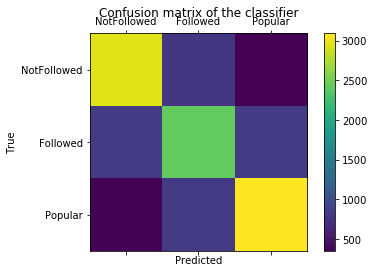

In [268]:
import matplotlib.pyplot as plt
labels =['NotFollowed','Followed','Popular']
cm = confusion_matrix(y_val, mod_pred, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
plt.draw()

In [269]:
mod_accuracy=accuracy_score(mod_pred,y_val)
print mod_accuracy

0.679820699592


In [270]:
from sklearn.externals import joblib
joblib.dump(model, 'rfmodel_multi.pkl') 

['rfmodel_multi.pkl']

# Actionable insights

In [70]:
thefile = open('topN.txt', 'w')
thefile.write("\n".join(topN))
fil=open('topN.txt','r')
lines = fil.read().splitlines()
lines


['model ',
 'stylish ',
 'love ',
 'model duty ',
 'swag ',
 'photography ',
 'instagood ',
 'nyfw ',
 'trend ',
 'celebs ',
 'urban ',
 'hypebeast ',
 'blogger ',
 'lookbook ',
 'beautiful ',
 'shoe ',
 'art ',
 'summer ',
 'apparel ',
 'grunge ',
 'nyc ',
 'photooftheday ',
 'candids ',
 'follow ',
 'beauty ',
 'photo ',
 'dope ',
 'cute ',
 'hipster ',
 'design ',
 's ',
 'picoftheday ',
 'indie ',
 'look ',
 'candid ',
 'paris ',
 'sexy ',
 'fresh ',
 'inspiration ',
 'denim ',
 'hot ',
 'kick ',
 'hair ',
 'vintage ',
 'newyork ',
 'gear ',
 'famous ',
 'luxury ',
 'black ',
 'travel ',
 'casual ',
 'lookoftheday ',
 'life ',
 'dress ',
 'hiphop ',
 'sneaker ',
 'instagram ',
 'likelike ',
 'adidas ',
 'instadaily ',
 'music ',
 'london ',
 'supreme ',
 'duty ',
 'designer ',
 'pfw ',
 'portrait ',
 'makeup ',
 'followme ',
 'kendall jenner ',
 'victoria secret ',
 'nike ',
 'actress ',
 'photoshoot ',
 'stylist ',
 'bella hadid ',
 'jean ',
 'trendy ',
 'august ',
 'graffiti ',
 

In [5]:
import cleantags_app

tagl=ststyle[ststyle['Popularity']=='Popular']['taglist']
taglnp=ststyle[ststyle['Popularity']=='NotFollowed']['taglist']
arraypop,topNpop=cleantags_app.tagextractor(tagl,50)
arraynp,topNnp=cleantags_app.tagextractor(taglnp,50)

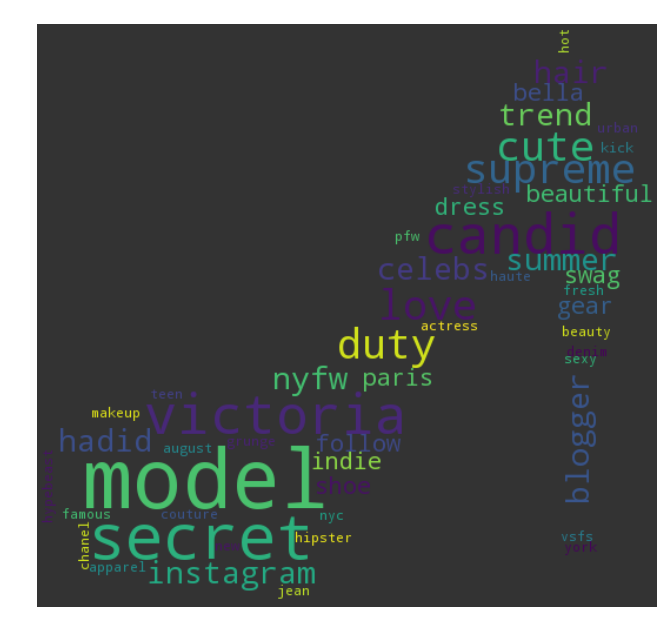

In [11]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS


plt.figure(num=None, figsize=(10,12), dpi=80, facecolor='w', edgecolor='k')
# Read the whole text.
text = ' '.join(topNpop)

# read the mask image
# taken from
# http://www.stencilry.org/stencils/movies/alice%20in%20wonderland/255fk.jpg
stiletto_mask = np.array(Image.open("data/image10.png"))

stopwords = set(STOPWORDS)
stopwords.add("said")

wc = WordCloud(background_color='#333333', max_words=200, mask=stiletto_mask,
               stopwords=stopwords)
# generate word cloud
wc.generate(text)

# store to file
wc.to_file( "cloud_popular.png")

# show
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
fig1 = plt.gcf()

plt.show()
plt.draw()
#fig1.savefig('cloud.png',transparent=True)

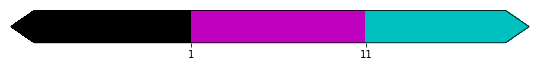

In [331]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig = plt.figure(figsize=(8, 3))

ax2 = fig.add_axes([0.05, 0.475, 0.9, 0.15])

cmap = mpl.colors.ListedColormap(['k','m', 'c'])
cmap.set_over('0.25')
cmap.set_under('0.75')

# If a ListedColormap is used, the length of the bounds array must be
# one greater than the length of the color list.  The bounds must be
# monotonically increasing.
bounds = [-8,1, 11,19]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
                                norm=norm,
                                # to use 'extend', you must
                                # specify two extra boundaries:
                                boundaries=[0] + bounds + [13],
                                extend='both',
                                ticks=[1,11],  # optional
                                spacing='proportional',
                                orientation='horizontal')
#cb2.set_label('Level of influence')

plt.show()

# SQL connection

In [ ]:
#My new data frame:

columns=['LOCATION_ID','STATE','STATE_FIPS','CZ_TYPE','CZ_FIPS','CZ_NAME','CZ_TIEMZONE']
location_ids = []
dfs = []

# The query I read for multiple tables and I want to add to the location_df
for table_name in table_names:

    sql_query = """
	SELECT "STATE","STATE_FIPS","CZ_TYPE","CZ_FIPS","CZ_NAME","CZ_TIMEZONE" FROM %s;
    """%table_name
    dfs.append(pd.read_sql_query(sql_query,con))

location_tables = pd.concat(dfs,axis=0,keys=location_ids,names=['location_id'])

In [ ]:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd

dbname = 'fposts'
username = 'vanniagm'


if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))






con = None
con = psycopg2.connect(database = dbname, user = username)

# query:
sql_query = """
SELECT * FROM birth_data_table WHERE delivery_method='Cesarean';
"""
birth_data_from_sql = pd.read_sql_query(sql_query,con)

birth_data_from_sql.head()

In [248]:
import pandas as pd
import datetime
import dateutil
from dateutil.rrule import *
from sqlalchemy import create_engine
import sqlite3
from sqlalchemy_utils import database_exists, create_database

#note that if you keep running this script, it will try to download the data over and over, so you should only run it once, and then do stuff based on the command at the end (in your own scripts)

#what you call your databse, will be in the same folder where you run this script, can also provide a full path if wanted
dbname = 'fposts'
username = 'vanniagm'

if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))


#very very quick and hacky way to do this initialize database (if database is already there it will fail, hence the try/pass)
try:
    conn=sqlite3.connect(dbname)
    c=conn.cursor()
    #i've loaded the page before to get the column headers and manually created cleaner ones here 
    #timestamps stored as text, and other numerical values are stored as reals, site is text
    c.execute('''
        CREATE TABLE NEWA(timestamp TEXT, Temp_F REAL, Rain_inches REAL , RH_percent REAL, Dewpoint_F REAL ,Wind_Spd_mph REAL, Wind_Dir_degrees REAL, Est_LW_minutes REAL, Site TEXT)
    ''')
    conn.commit()
    #conn.close()
except:
    pass

disk_engine = create_engine('sqlite:///'+dbname)

#i picked 3 stations from the internet website, central park, la guardia ariport, jfk airport
stations=['knyc','klga','kjfk']

#this is to pick months from start to end (doing this with datetime was harder than it looked)
months=[dt.strftime('%Y/%-m') for dt in rrule(MONTHLY, dtstart=datetime.date(2016, 2, 1), until=datetime.date(2016,5,1))]

#now that the tables are created, we get the manually defined headers earlier and store them in memory so that we can feed them into the pandas to sql command later and properly organize our data
db_cols = pd.read_sql("select * from NEWA", disk_engine).columns.tolist()

for station in stations:
    for month in months:
        
        command='http://newa.nrcc.cornell.edu/newaLister/hly/'+station+'/'+month
        print command

        dfs = pd.read_html(command)
        #get rid of weird headers
        df_clean=dfs[0].drop([0,1])
        #this adds a whole column with our station name, will be useful later for querying data
        df_clean['Site']=station
        df_clean.columns=db_cols
        #this selects the table that we created (NEWA) and doesn't keep the index from the dataframe
        df_clean.to_sql('NEWA',disk_engine,index=False, if_exists='append')

#if this worked, you've built a database from web data (though the page was easy to scape). 

#once this is done, we can do something like (or in another script)
#this selects a specific subset of data from a single station between specific timestamps and organizes them in chronological order
#note the weird escape characters for the time stamp apostrophes
data = pd.read_sql_query("select * from NEWA where site='knyc' and timestamp between \"02/29/2016 21:00\" and \"03/29/2016 21:00\" order by timestamp ASC;", conn)

#have fun!

http://newa.nrcc.cornell.edu/newaLister/hly/knyc/2016/2
http://newa.nrcc.cornell.edu/newaLister/hly/knyc/2016/3
http://newa.nrcc.cornell.edu/newaLister/hly/knyc/2016/4
http://newa.nrcc.cornell.edu/newaLister/hly/knyc/2016/5
http://newa.nrcc.cornell.edu/newaLister/hly/klga/2016/2
http://newa.nrcc.cornell.edu/newaLister/hly/klga/2016/3
http://newa.nrcc.cornell.edu/newaLister/hly/klga/2016/4
http://newa.nrcc.cornell.edu/newaLister/hly/klga/2016/5
http://newa.nrcc.cornell.edu/newaLister/hly/kjfk/2016/2
http://newa.nrcc.cornell.edu/newaLister/hly/kjfk/2016/3
http://newa.nrcc.cornell.edu/newaLister/hly/kjfk/2016/4
http://newa.nrcc.cornell.edu/newaLister/hly/kjfk/2016/5


In [56]:
ststyle['note_countlog']

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
5       0.000000
6       0.301030
7       0.845098
8       0.778151
9       0.602060
10      0.000000
11      0.602060
12      0.301030
13      0.000000
14      0.000000
15      0.000000
16      0.000000
17      0.000000
18      0.845098
19      0.698970
20      0.301030
21      0.301030
22      0.000000
23      0.000000
24      0.602060
25      0.477121
26      0.000000
27      0.698970
28      0.000000
29      0.000000
          ...   
9970    1.255273
9971    0.000000
9972    1.113943
9973    2.060698
9974    2.082785
9975    1.322219
9976    0.698970
9977    0.698970
9978    2.214844
9979    1.278754
9980    1.602060
9981    1.556303
9982    1.447158
9983    1.973128
9984    1.518514
9985    1.698970
9986    1.322219
9987    0.602060
9988    0.845098
9989    0.000000
9990    0.477121
9991    1.301030
9992    0.000000
9993    0.000000
9994    0.903090
9995    0.698970
9996    1.778151
9997    0.0000

In [269]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sentences=(ststyle['words']).astype(str).iloc[1:20]


analyzer = SentimentIntensityAnalyzer()
for sentence in sentences:
    vs = analyzer.polarity_scores(sentence)
    print("{:-<65} {}".format(sentence, str(vs)))

nan-------------------------------------------------------------- {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
rick owen geobasketsjoin clvn ----------------------------------- {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
secret happiness human connection quote catgrant supergirl travelthrowback takemeback streetview streetphotography edinburgh scotland uk edinburgh uk travel travelgram unitedkingdom bisnarvoyager ndaylenspinup latepost latergram streetstyle street buildingporn architecture ndaylensgratefulheart edinburgh united kingdom  {'neg': 0.0, 'neu': 0.819, 'pos': 0.181, 'compound': 0.7506}
gagdrawings lover kiss art streetart streetstyle urbanart artlover sky love sprayart artwork contemporaryart cool minimal arte woman portrait contemporaryart photooftheday sculpture presso milan italy  {'neg': 0.0, 'neu': 0.604, 'pos': 0.396, 'compound': 0.9201}
street chic style http ift tt jomkbh ---------------------------- {'neg': 0.0, 'neu': 0.741, 'pos': 0.259, 'compou